# Classification using random and Nyström features.

Author: <alberto.suarez@uam.es>

In this notebook we illustrate the use of random and Nystöm features with linear SVMs to carry out non-linear classification.

In [77]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import kernel_approximation as ka

from sklearn import svm
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.kernel_approximation import RBFSampler
from sklearn import datasets

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
"""
# A simple 2 D problem
np.random.seed(0)
n_samples = 300
X = np.random.randn(n_samples, 2)
Y = np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)
"""
# A not so simple 2 D problem
noise = 0.3

# Training set 
X, y = datasets.make_moons(n_samples=100, noise=noise, random_state=0)

# Test set 
X_test, y_test = datasets.make_moons(n_samples=1000, noise=noise)

# Compute grid of points for plotting the decision regions

grid_x1, grid_x2 = np.meshgrid(
    np.linspace(-3, 3, 50),
    np.linspace(-3, 3, 50),
)

grid_X = np.c_[grid_x1.ravel(), grid_x2.ravel()]

# Plot the decision regions 
def plot_decision_regions(X, y, grid_x1, grid_x2, features_grid, clf):

    # plot the decision function for each datapoint on the grid
    Z = clf.decision_function(features_grid)
    Z = Z.reshape(grid_x1.shape)


    plt.imshow(Z, interpolation='nearest',
    extent=(grid_x1.min(), grid_x1.max(), grid_x2.min(), grid_x2.max()), aspect='auto',
    origin='lower', cmap=plt.cm.PuOr_r)

    contours = plt.contour(grid_x1, grid_x2, Z, levels=[0], linewidths=2,
    linestyles='dashed')
    plt.scatter(X[:, 0], X[:, 1], s=30, c=y, cmap=plt.cm.Paired,
    edgecolors='k')
    plt.xticks(())
    plt.yticks(())
    plt.axis([np.min(grid_x1), np.max(grid_x1), np.min(grid_x2), np.max(grid_x2)])
    plt.show()

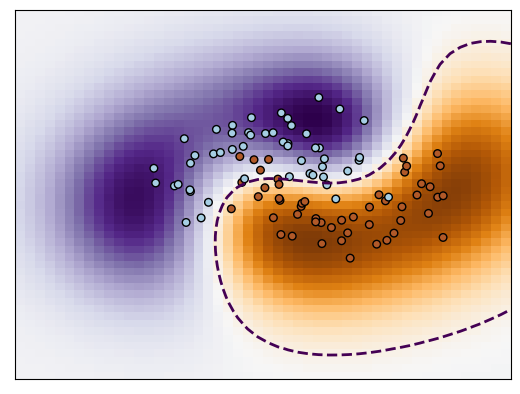

In [79]:
# Nonlinear SVM 

gamma = 0.5
sigma = np.sqrt(1.0 / 2.0 / gamma)

clf = svm.SVC(kernel='rbf', gamma=gamma)
# clf = svm.NuSVC(gamma=gamma)

clf.fit(X, y)

plot_decision_regions(X, y, grid_x1, grid_x2, grid_X, clf)

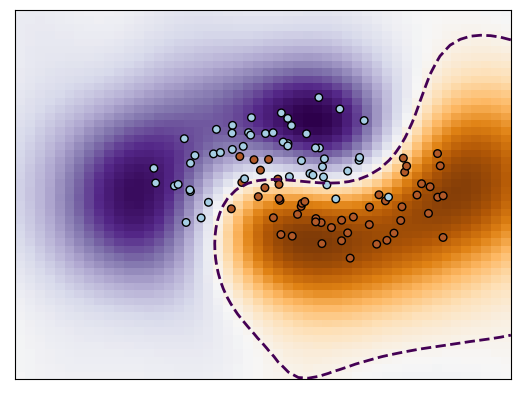

In [80]:
# RBF Fourier random features (sklearn)

n_random_features = 10000

rbf_sampler = RBFSampler(gamma=gamma, n_components=n_random_features, random_state=1)
random_features = rbf_sampler.fit_transform(X)
random_features_grid = rbf_sampler.fit_transform(grid_X)

clf = svm.SVC(kernel='linear')
# clf = svm.NuSVC(gamma='auto')

clf.fit(random_features, y)

plot_decision_regions(X, y, grid_x1, grid_x2, random_features_grid, clf)

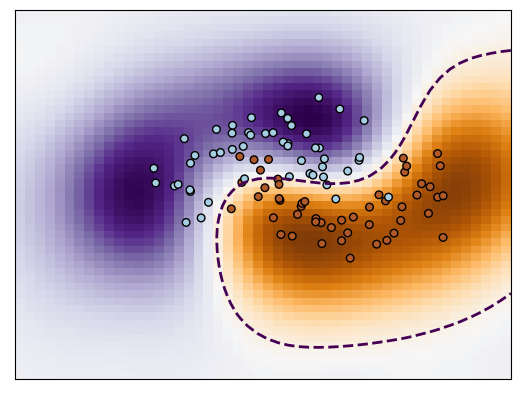

In [81]:
# RBF Fourier random features (our implementation)

rbf_sampler = ka.RandomFeaturesSamplerRBF(sigma)
random_features = rbf_sampler.fit_transform(n_random_features, X)
random_features_grid = rbf_sampler.transform(grid_X)

clf = svm.SVC(kernel='linear')
# clf = svm.NuSVC(gamma='auto')
clf.fit(random_features, y)


plot_decision_regions(X, y, grid_x1, grid_x2, random_features_grid, clf)

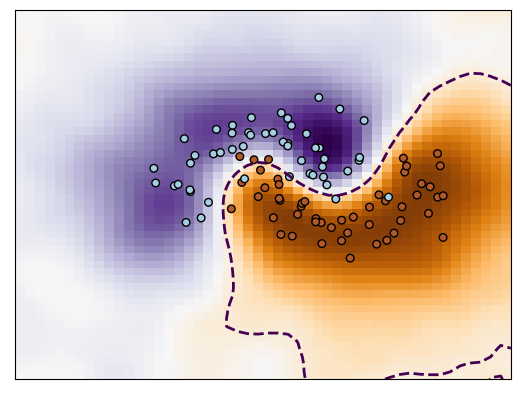

In [82]:
# Matérn Fourier random features (our implementation)
length_scale = sigma
nu = 1.5

matern_sampler = ka.RandomFeaturesSamplerMatern(length_scale, nu)    
random_features = matern_sampler.fit_transform(n_random_features, X)
random_features_grid = matern_sampler.transform(grid_X)

clf = svm.SVC(kernel='linear')
clf.fit(random_features, y)

plot_decision_regions(X, y, grid_x1, grid_x2, random_features_grid, clf)

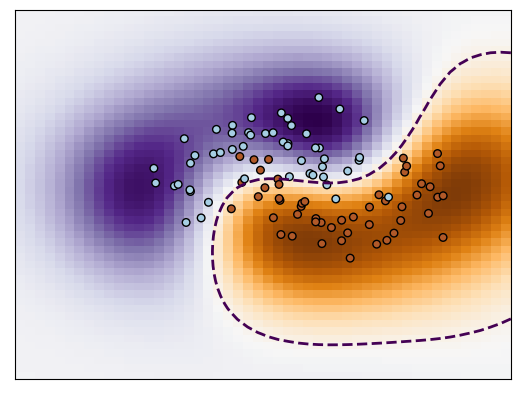

In [83]:
# Nystroem features (our implementation)

# Kernel matrix
def kernel(X, Y):
    return rbf_kernel(X, Y, gamma=gamma) 

n_nystroem_features = 20
# n_nystroem_features = len(X) # Recovers full kernel

nystroem_sampler = ka.NystroemFeaturesSampler(kernel)
nystroem_features = nystroem_sampler.fit_transform(n_nystroem_features, X)
nystroem_features_grid = nystroem_sampler.transform(grid_X)

clf = svm.SVC(kernel='linear')
clf.fit(nystroem_features, y)

plot_decision_regions(X, y, grid_x1, grid_x2, nystroem_features_grid, clf)

## Exercises

1. Afer having scaled the data to the range $[-1, 1]$ using sklearn's *MinMaxScaler*, determine the optimal hyperparameters (gamma, nu) and the optimal number of features for the different classifiers consideres in this example using CV on the training set. Compare the prediction error of the different classifiers in the test set $\left\{X_{test}, y_{test} \right\}$. 

References:
https://scikit-learn.org/stable/modules/preprocessing.html

https://scikit-learn.org/stable/auto_examples/model_selection/plot_grid_search_digits.html#sphx-glr-auto-examples-model-selection-plot-grid-search-digits-py



In [84]:
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = preprocessing.MinMaxScaler((-1,1))
X = min_max_scaler.fit_transform(X)
X
X_test= min_max_scaler.transform(X_test)

In [85]:
# Nonlinear SVM 
from sklearn.model_selection import GridSearchCV

tuned_parameters = {"gamma": np.linspace(1e-10,10,50)}

clf = svm.SVC(kernel='rbf')

GS = GridSearchCV(estimator = clf,
                  param_grid = tuned_parameters,
                  scoring = ["r2", "neg_root_mean_squared_error"],
                  refit = "r2",
                  cv = 5,
                  verbose = 4)   

GS.fit(X,y)


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END gamma=1e-10; neg_root_mean_squared_error: (test=-0.548) r2: (test=-0.200) total time=   0.0s
[CV 2/5] END gamma=1e-10; neg_root_mean_squared_error: (test=-0.316) r2: (test=0.600) total time=   0.0s
[CV 3/5] END gamma=1e-10; neg_root_mean_squared_error: (test=-0.592) r2: (test=-0.400) total time=   0.0s
[CV 4/5] END gamma=1e-10; neg_root_mean_squared_error: (test=-0.000) r2: (test=1.000) total time=   0.0s
[CV 5/5] END gamma=1e-10; neg_root_mean_squared_error: (test=-0.316) r2: (test=0.600) total time=   0.0s
[CV 1/5] END gamma=0.20408163275102043; neg_root_mean_squared_error: (test=-0.500) r2: (test=0.000) total time=   0.0s
[CV 2/5] END gamma=0.20408163275102043; neg_root_mean_squared_error: (test=-0.387) r2: (test=0.400) total time=   0.0s
[CV 3/5] END gamma=0.20408163275102043; neg_root_mean_squared_error: (test=-0.592) r2: (test=-0.400) total time=   0.0s
[CV 4/5] END gamma=0.20408163275102043; neg_root_mean

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'gamma': array([1.00000000e-10, 2.04081633e-01, 4.08163265e-01, 6.12244898e-01,
       8.16326531e-01, 1.02040816e+00, 1.22448980e+00, 1.42857143e+00,
       1.63265306e+00, 1.83673469e+00, 2.04081633e+00, 2.24489796e+00,
       2.44897959e+00, 2.65306122e+00, 2.85714286e+00, 3.06122449e+00,
       3.26530612e+00, 3.46938776e+00, 3.67346939e+00, 3.87...
       5.71428571e+00, 5.91836735e+00, 6.12244898e+00, 6.32653061e+00,
       6.53061224e+00, 6.73469388e+00, 6.93877551e+00, 7.14285714e+00,
       7.34693878e+00, 7.55102041e+00, 7.75510204e+00, 7.95918367e+00,
       8.16326531e+00, 8.36734694e+00, 8.57142857e+00, 8.77551020e+00,
       8.97959184e+00, 9.18367347e+00, 9.38775510e+00, 9.59183673e+00,
       9.79591837e+00, 1.00000000e+01])},
             refit='r2', scoring=['r2', 'neg_root_mean_squared_error'],
             verbose=4)

In [86]:

print('The best estimator is: \n',GS.best_estimator_)
print('The best parameters is: \n',GS.best_params_)
print('The best score is: \n',GS.best_score_)

The best estimator is: 
 SVC(gamma=6.734693877583673)
The best parameters is: 
 {'gamma': 6.734693877583673}
The best score is: 
 0.76


In [ ]:
from sklearn.pipeline import Pipeline

clf = svm.SVC(kernel='linear')

pipe = Pipeline([
    ('rbfs', RBFSampler(random_state=1)),
    ('clf', clf),
])


tuned_parameters = {"rbfs__gamma": np.linspace(0,10,50), "rbfs__n_components": [100,1000,10000,100000]}


GS = GridSearchCV(estimator = pipe,
                  param_grid = tuned_parameters,
                  scoring = ["r2", "neg_root_mean_squared_error"],
                  refit = "r2",
                  cv = 5,
                  verbose = 4)   

GS.fit(X, y)

In [87]:
print('The best estimator is: \n',GS.best_estimator_)
print('The best parameters is: \n',GS.best_params_)
print('The best score is: \n',GS.best_score_)

The best estimator is: 
 SVC(gamma=6.734693877583673)
The best parameters is: 
 {'gamma': 6.734693877583673}
The best score is: 
 0.76


In [88]:
# Cosas eliminar cv de n_features (debe ser un valor fijo mayor o igual que 2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score


X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.33, random_state=42)

model = svm.SVC(kernel='rbf')
# Rango de gamma y n_random_features a probar
gammas = np.linspace(2e-10, 10, 50)
n_random_features = [10, 20, 50, 100, 250, 500]

# Matrices de resultados
results_gamma = np.zeros_like(gammas)
n_random_features = 3

nrf = 20
# Validación cruzada de gamma
for i, gamma in enumerate(gammas):
    sigma = np.sqrt(1.0 / 2.0 / gamma)
    rbf_sampler = ka.RandomFeaturesSamplerRBF(sigma)
    random_features = rbf_sampler.fit_transform(n_random_features, X_train)
    model.fit(random_features, y_train)
    
    y_pred = model.predict(rbf_sampler.transform(X_cv))
    results_gamma[i] =  r2_score(y_cv, y_pred)

mejor_gamma = gammas[np.argmax(results_gamma)]
sigma = np.sqrt(1.0 / 2.0 / mejor_gamma)



# Imprimir resultados
print("Resultados de validación cruzada de gamma:")
print(results_gamma)
print("Mejor valor de gamma:", gammas[np.argmax(results_gamma)])
print("")


Resultados de validación cruzada de gamma:
[-1.0625      0.27205882  0.39338235  0.27205882  0.02941176  0.02941176
  0.27205882  0.39338235 -0.09191176  0.15073529 -0.21323529 -0.45588235
 -0.45588235 -0.57720588  0.02941176  0.51470588 -0.57720588 -0.33455882
 -0.21323529 -1.30514706 -0.69852941 -1.0625     -0.33455882 -0.09191176
  0.51470588 -1.0625      0.15073529  0.15073529 -0.69852941  0.39338235
 -0.45588235 -0.21323529  0.15073529 -0.94117647 -0.09191176 -0.09191176
 -0.21323529 -0.45588235 -0.09191176 -0.81985294 -1.18382353  0.51470588
 -1.0625     -0.57720588 -1.42647059 -0.09191176 -0.57720588 -0.45588235
 -0.33455882 -0.69852941]
Mejor valor de gamma: 3.061224489934694



In [92]:
# Matérn Fourier random features (our implementation)

length_scale = sigma
nu = 1.5


model = svm.SVC(kernel='linear')

# Rango sigmas y nu a probar
gammas = np.linspace(2e-10, 10, 50)
nus = np.linspace(2e-10, 10, 50)

# Matrices de resultados
results_sigma = np.zeros_like(gammas)
results_nu = np.zeros_like(nus)

mejor_nrf = 3


    
# Validación cruzada de gamma
for i, gamma in enumerate(gammas):
    sigma = np.sqrt(1.0 / 2.0 / gamma)
    matern_sampler = ka.RandomFeaturesSamplerMatern(sigma, nu)    
    random_features = matern_sampler.fit_transform(mejor_nrf, X_train)
    model.fit(random_features, y_train)
    y_pred = model.predict(rbf_sampler.transform(X_cv))
    results_gamma[i] =  r2_score(y_cv, y_pred)

mejor_gamma = gammas[np.argmax(results_gamma)]
mejor_sigma = np.sqrt(1.0 / 2.0 / mejor_gamma)

# Imprimir resultados
print("Resultados de validación cruzada de gamma:")
print(results_gamma)
print("Mejor valor de gamma:", mejor_gamma)
print("")


Resultados de validación cruzada de gamma:
[-1.0625     -0.45588235 -0.45588235 -1.54779412 -1.54779412 -0.45588235
 -1.54779412 -0.57720588 -1.54779412 -1.0625     -0.57720588 -0.57720588
 -0.69852941 -1.54779412 -0.57720588 -0.33455882 -1.54779412 -0.57720588
 -0.45588235 -0.33455882 -1.54779412 -0.94117647 -1.66911765 -1.66911765
 -0.45588235 -0.57720588 -0.45588235 -1.42647059 -0.69852941 -1.54779412
 -0.33455882 -1.42647059 -0.81985294 -0.69852941 -0.45588235 -0.33455882
 -1.30514706 -0.69852941 -0.33455882 -0.45588235 -1.42647059 -1.54779412
 -0.57720588 -1.66911765 -1.66911765 -1.30514706 -1.42647059 -1.66911765
 -1.0625     -1.30514706]
Mejor valor de gamma: 3.061224489934694



In [93]:
# Nystroem features (our implementation)

model = svm.SVC(kernel='rbf')
# Rango de gamma y n_random_features a probar
gammas = np.linspace(2e-10, 10, 50)


# Matrices de resultados
results_gamma = np.zeros_like(gammas)


n_nystroem_features = 20
# Validación cruzada de gamma
for i, gamma in enumerate(gammas):
    sigma = np.sqrt(1.0 / 2.0 / gamma)
    # Kernel matrix
    def kernel(X, Y):
        return rbf_kernel(X, Y, gamma=gamma) 

    nystroem_sampler = ka.NystroemFeaturesSampler(kernel)
    nystroem_features = nystroem_sampler.fit_transform(n_nystroem_features, X_train)
    # fin del entrenamiento saca las features
    # entrenamos la svm con las características
    model.fit(random_features, y_train)
    y_pred = model.predict(rbf_sampler.transform(X_cv))
    results_gamma[i] =  r2_score(y_cv, y_pred)

mejor_gamma_Nystroem = gammas[np.argmax(results_gamma)]




# Imprimir resultados
print("Resultados de validación cruzada de gamma:")
print(results_gamma)
print("Mejor valor de gamma:", gammas[np.argmax(results_gamma)])
print("")





Resultados de validación cruzada de gamma:
[-1.0625 -1.0625 -1.0625 -1.0625 -1.0625 -1.0625 -1.0625 -1.0625 -1.0625
 -1.0625 -1.0625 -1.0625 -1.0625 -1.0625 -1.0625 -1.0625 -1.0625 -1.0625
 -1.0625 -1.0625 -1.0625 -1.0625 -1.0625 -1.0625 -1.0625 -1.0625 -1.0625
 -1.0625 -1.0625 -1.0625 -1.0625 -1.0625 -1.0625 -1.0625 -1.0625 -1.0625
 -1.0625 -1.0625 -1.0625 -1.0625 -1.0625 -1.0625 -1.0625 -1.0625 -1.0625
 -1.0625 -1.0625 -1.0625 -1.0625 -1.0625]
Mejor valor de gamma: 2e-10



Código para aplicar los algoritmos óptimos al conjunto de test. Hay que decidir si se ponen todos juntos aquí o después de cada método.

In [105]:
#Caso rbf
sigma = np.sqrt(1.0 / 2.0 / gamma)
rbf_sampler = ka.RandomFeaturesSamplerRBF(sigma)
random_features = rbf_sampler.fit_transform(n_random_features, X)
model.fit(random_features, y)
y_pred = model.predict(rbf_sampler.transform(X_test))
print(r2_score(y_test, y_pred))

-0.544


In [103]:
#Caso matern
sigma = np.sqrt(1.0 / 2.0 / gamma)
matern_sampler = ka.RandomFeaturesSamplerMatern(sigma, nu)    
random_features = matern_sampler.fit_transform(mejor_nrf, X)
model.fit(random_features, y)
y_pred = model.predict(rbf_sampler.transform(X_test))
print( r2_score(y_test, y_pred))

-1.3159999999999998


In [100]:
#Caso gamma Nystroem
sigma = np.sqrt(1.0 / 2.0 / mejor_gamma_Nystroem)
def kernel(X, Y):
    return rbf_kernel(X, Y, gamma=gamma) 
nystroem_sampler = ka.NystroemFeaturesSampler(kernel)
nystroem_features = nystroem_sampler.fit_transform(n_nystroem_features, X_train)
model.fit(random_features, y_train)
y_pred = model.predict(rbf_sampler.transform(X_test))
print( r2_score(y_test, y_pred))


-1.1960000000000002


In [ ]:
from sklearn import metrics 

y_pred = GS.predict(X_test)
print("Accuracy: ",metrics.accuracy_score(y_test, y_pred))


Accuracy:  0.686


El mejor modelo es el primero. 